In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import sklearn
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error,mean_squared_error
import os

Forecasting-based anomaly detection is a common approach for network traffic monitoring.
In this notebook, we apply a Seasonal ARIMA (SARIMA) model to a real-world network traffic time series dataset (CESNET-TimeSeries24)
Our goal is to forecast future traffic and identify anomalies where actual traffic significantly deviates from the forecast. We follow the dataset authors' baseline method, using a SARIMA model with weekly seasonality, and compare a one-shot 7-day forecast to a one-shot 2-day forecast. We also implement a rolling forecast with periodic retraining to simulate continuous monitoring. Finally, we evaluate the forecasts with common error metrics and perform anomaly detection based on prediction intervals.

###### ================================ 1. Data Loading================================

The code below reads the hourly timestamps and the metrics for IP 103, merges them, and fills any missing hour with 0 flows. We then isolate the n_flows series for further analysis. First, we load the time series data from CSV files and prepare it for analysis. The dataset provides time-indexed traffic metrics (aggregated hourly). 

In [3]:
data_path = r"C:\Users\sabid\OneDrive\Documents\Tanjila\cesnet-timeseries24\ip_addresses_sample\agg_1_hour\103.csv"
times_path = r"C:\Users\sabid\OneDrive\Documents\Tanjila\cesnet-timeseries24\times\times_1_hour.csv"

# Load CSVs
ip_df = pd.read_csv(data_path)
times_df = pd.read_csv(times_path)

# convert to datetime
times_df['time'] = pd.to_datetime(times_df['time'])

# Select the relevant columns: id_time and n_flows (number of flows in each hour)
ip_df = ip_df[['id_time', 'n_flows']]

###### ================================ 2. Data Preprocessing ================================

We need to merge the main data with a timestamp reference (if timestamps are stored separately), set the datetime index, and handle any missing time intervals.
Merge timestamps: Combine the data with actual timestamps if the data file uses time IDs.
Set datetime index: Convert the timestamp column to DateTimeIndex with hourly frequency.
Handle gaps: Fill any missing hours in the sequence (e.g. if an hour had no traffic, fill with 0) to maintain a continuous time series.

In [4]:
# Align IP data with the full timeline of 1-hour intervals
# Using the times index (all id_time from start to end) and filling missing with 0
df = pd.merge(times_df, ip_df, on="id_time", how="left").sort_values("id_time")
df["n_flows"] = df["n_flows"].fillna(0)

# Set timestamp as index with hourly frequency
df.set_index("time", inplace=True)
df = df.asfreq("h")

# Summary statistics for the number of flows per hour
print(df["n_flows"].describe())

count      6718.000000
mean      21358.236231
std       24879.214597
min           0.000000
25%        5198.750000
50%       11943.000000
75%       25610.750000
max      137970.000000
Name: n_flows, dtype: float64


###### ================================ 2. Plotting Target Series (n_flows) ================================

The dataset contains 6,718 hourly observations (~40 weeks). The average flow count is 21,358/hour, while the maximum spikes to 137,970, over 6× the mean likely a DoS or anomaly event. A high standard deviation (24,879) indicates significant variability, typical of real network traffic. The median (11,943) is much lower than the mean, and 25% of values fall below ~5,199, confirming a positively skewed, long-tailed distribution. The 75th percentile (25,611) suggests that a quarter of hours experience heavy traffic. The minimum value is 0, likely from hours with no activity or missing data filled as zero. These stats reflect regular patterns with occasional extreme deviations—supporting the use of forecast-based anomaly detection.

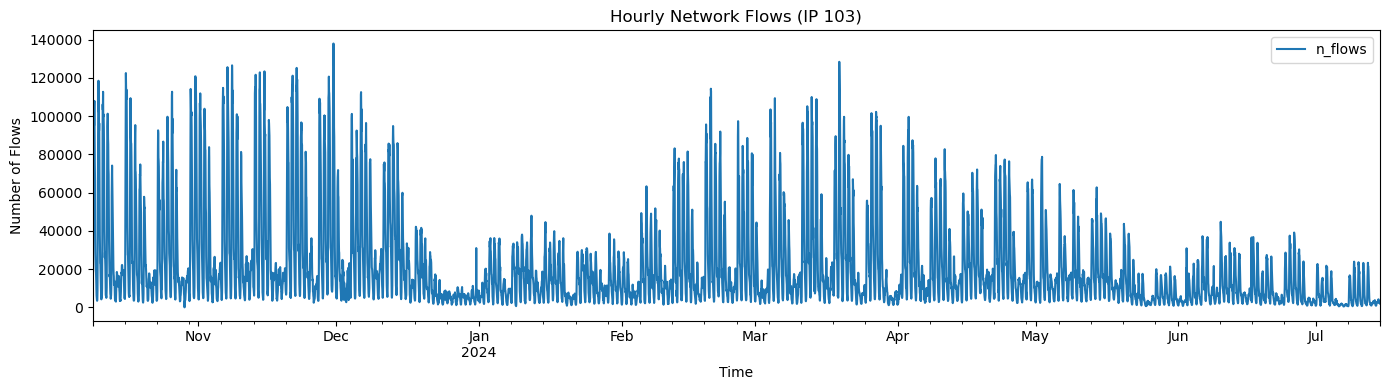

In [5]:
# Plot complete time series
df["n_flows"].plot(title="Hourly Network Flows (IP 103)", figsize=(14, 4))
plt.ylabel("Number of Flows")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.savefig("n_flow_plot.png", dpi=300, bbox_inches='tight')
plt.show()

A repeating weekly pattern, where traffic rises and falls in a cyclical way, this is seasonality in the network.

###### ================================ 3. One-shot SARIMA forecast with config I (1,1,1)(1,1,0,168) for 7 Days ================================

Fit SARIMA: Train the SARIMA(1,1,1)(1,1,1,168) model on the training data. Training window of 21 days (504 hours)
Forecast 7 days ahead: Generate a 168-hour forecast.
Evaluate: Compute evaluation metrics on the forecast vs actual test data – Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), R² (coefficient of determination), and Symmetric Mean Absolute Percentage Error (SMAPE).
Visualize: Plot the actual vs forecast values over the 7-day test period.

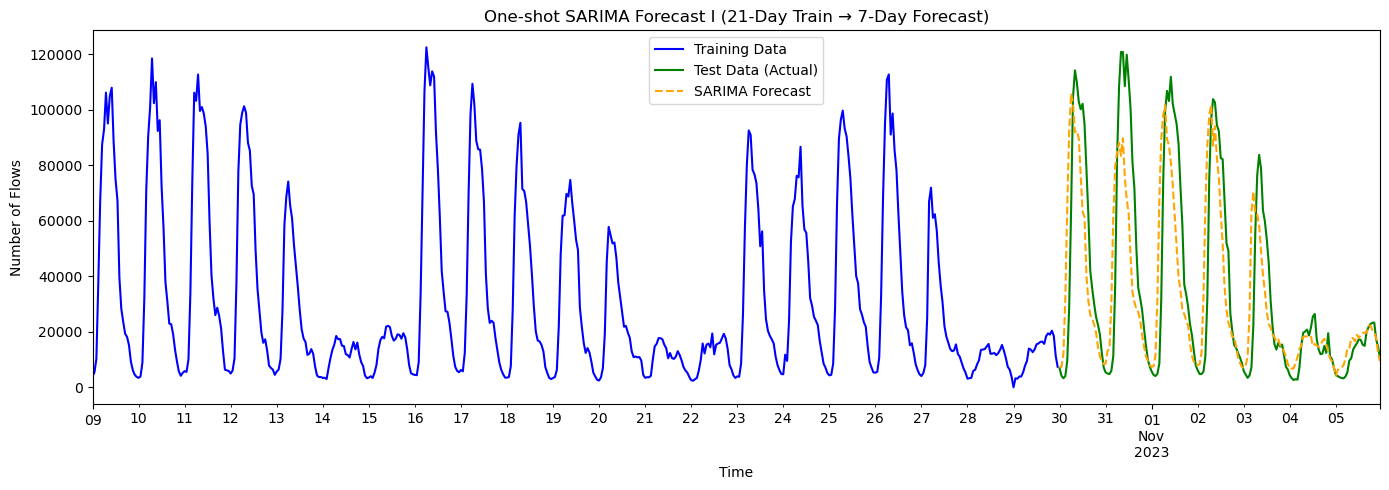

Forecast Evaluation (One-shot SARIMA I 7 Days):
RMSE:  21817.59 flows/hour
MAE:   14495.45 flows/hour
R²:    0.635
SMAPE: 43.78%


In [12]:
# Parameters
order = (1, 1, 1)
seasonal_order = (1, 1, 0, 168)
train_window = 24 * 21  # 504 hours ≈ 3 weeks
forecast_horizon = 24 * 7 # 168 hours = 1 week

# Ensure DataFrame is sorted by time
df = df.sort_index()

# Define train and test slices
train_series = df['n_flows'].iloc[:train_window]
test_series = df['n_flows'].iloc[train_window:train_window + forecast_horizon]

# Fit SARIMA on training data
sarima_model = SARIMAX(train_series, order=order, seasonal_order=seasonal_order)
sarima_result = sarima_model.fit(disp=False)

# Forecast the next 7 days
forecast = sarima_result.forecast(steps=forecast_horizon)
forecast.index = test_series.index  # Align forecast with actual

# Plot forecast vs actual
plt.figure(figsize=(14, 5))
train_series.plot(label="Training Data", color='blue')
test_series.plot(label="Test Data (Actual)", color='green')
forecast.plot(label="SARIMA Forecast", color='orange', linestyle='--')

plt.title("One-shot SARIMA Forecast I (21-Day Train → 7-Day Forecast)")
plt.xlabel("Time")
plt.ylabel("Number of Flows")
plt.legend()
plt.tight_layout()
plt.savefig("SARIMA_1shotI_7day.png", dpi=300, bbox_inches='tight')
plt.show()

# Evaluate forecast
rmse = np.sqrt(mean_squared_error(test_series, forecast))
mae = mean_absolute_error(test_series, forecast)
r2 = r2_score(test_series, forecast)

# Compute SMAPE 
numerator = np.abs(test_series - forecast)
denominator = (np.abs(test_series) + np.abs(forecast)) / 2
smape = 100 * np.mean(np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0))

print("Forecast Evaluation (One-shot SARIMA I 7 Days):")
print(f"RMSE:  {rmse:.2f} flows/hour")
print(f"MAE:   {mae:.2f} flows/hour")
print(f"R²:    {r2:.3f}")
print(f"SMAPE: {smape:.2f}%")

================================ 4. One-shot SARIMA forecast I Anomaly Detection ================================

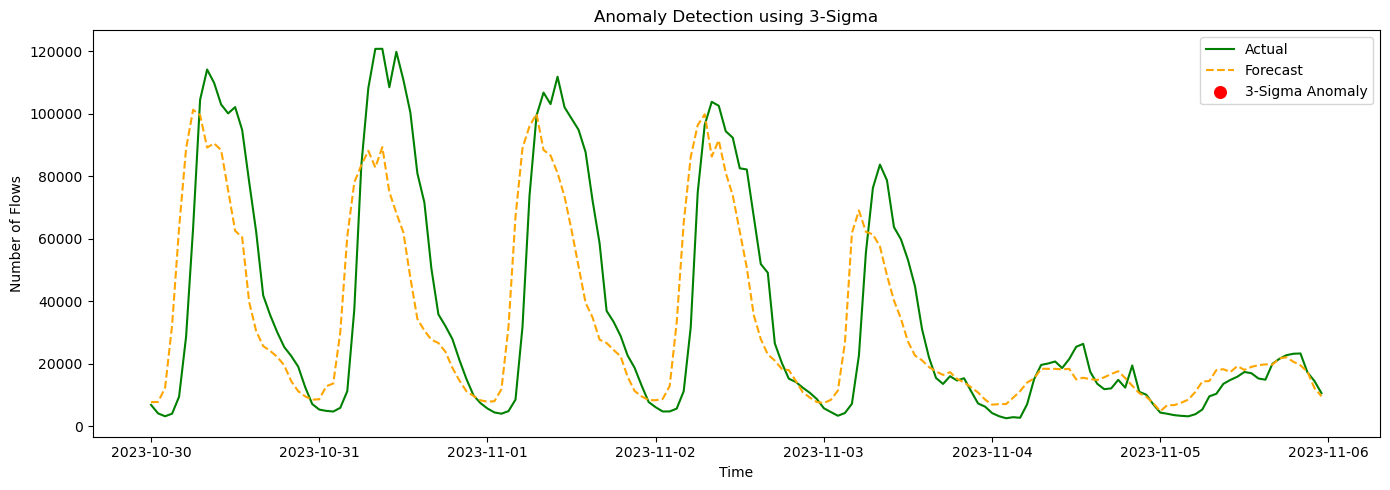

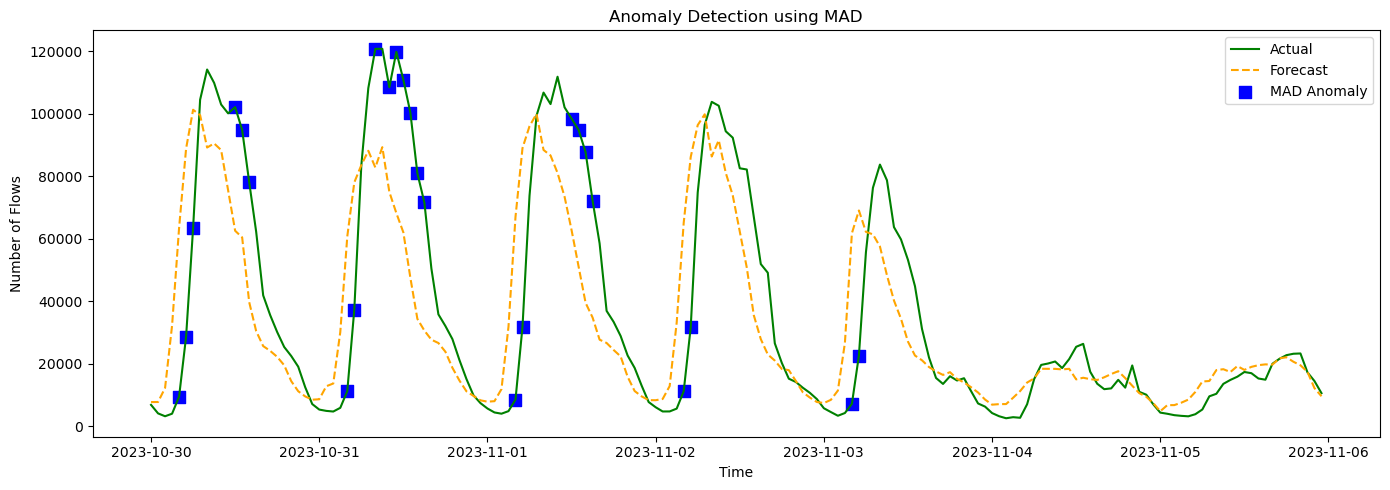

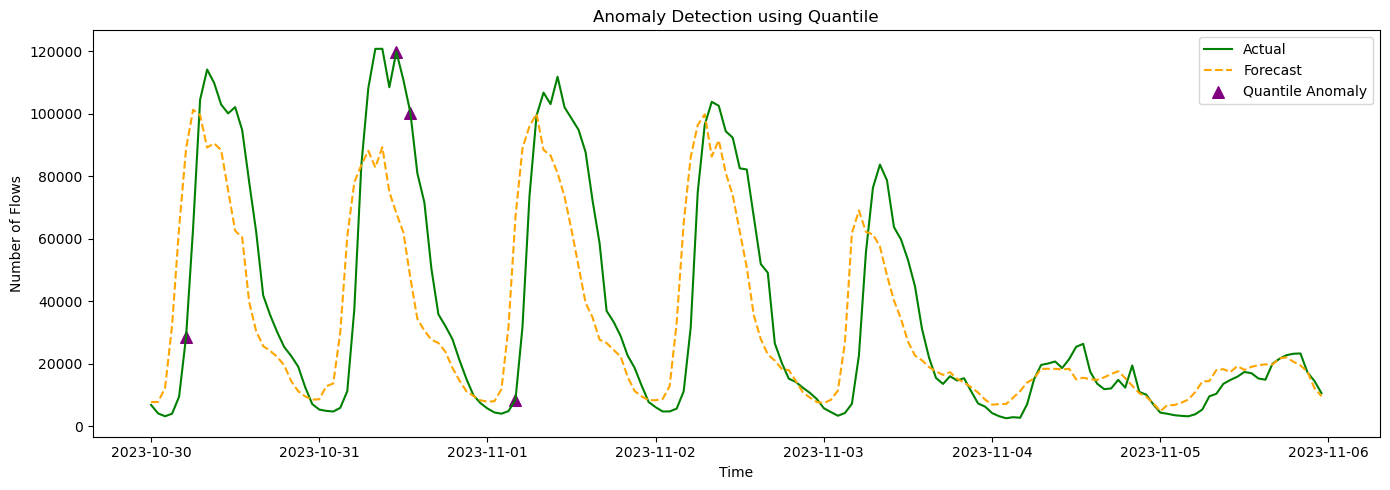

Anomalies Detected in Test Period:
• 3-Sigma method      : 0 points
• MAD method          : 25 points
• Quantile method     : 4 points


In [10]:
# Residuals (168 values) 
residuals = test_series - forecast

# 3-Sigma Detection
res_mean = residuals.mean()
res_std = residuals.std()
anomalies_3sigma = (residuals > res_mean + 3 * res_std) | (residuals < res_mean - 3 * res_std)

# MAD Detection
med = residuals.median()
mad = np.median(np.abs(residuals - med))
mad_scaled = 1.4826 * mad
anomalies_mad = (residuals > med + 3 * mad_scaled) | (residuals < med - 3 * mad_scaled)

# Quantile Detection
q_lo = residuals.quantile(0.01)
q_hi = residuals.quantile(0.99)
anomalies_quant = (residuals < q_lo) | (residuals > q_hi)

def plot_anomaly_method(series, forecast, anomaly_mask, method_name, color, marker):
    series = series.copy()
    forecast = forecast.copy()
    anomaly_mask = anomaly_mask.reindex(series.index, fill_value=False)  # align by index
    
    plt.figure(figsize=(14, 5))
    plt.plot(series.index, series, label='Actual', color='green')
    plt.plot(forecast.index, forecast, label='Forecast', color='orange', linestyle='--')
    plt.scatter(series.index[anomaly_mask], series[anomaly_mask],
                color=color, s=70, marker=marker, label=f'{method_name} Anomaly')
    plt.title(f'Anomaly Detection using {method_name}')
    plt.xlabel("Time")
    plt.ylabel("Number of Flows")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call for each
plot_anomaly_method(test_series, forecast, anomalies_3sigma, "3-Sigma", 'red', 'o')
plot_anomaly_method(test_series, forecast, anomalies_mad, "MAD", 'blue', 's')
plot_anomaly_method(test_series, forecast, anomalies_quant, "Quantile", 'purple', '^')

print("Anomalies Detected in Test Period:")
print(f"• 3-Sigma method      : {anomalies_3sigma.sum()} points")
print(f"• MAD method          : {anomalies_mad.sum()} points")
print(f"• Quantile method     : {anomalies_quant.sum()} points")

================================ 5. One-shot SARIMA forecast II (7 days vs 2 Days) ================================

Fit SARIMA: Train the SARIMA(1,0,0)(0,1,0,168) model on the training data. Training window of 31 days (504 hours) Forecast 7 days and 2 days ahead: Generate a 168-hour forecast.

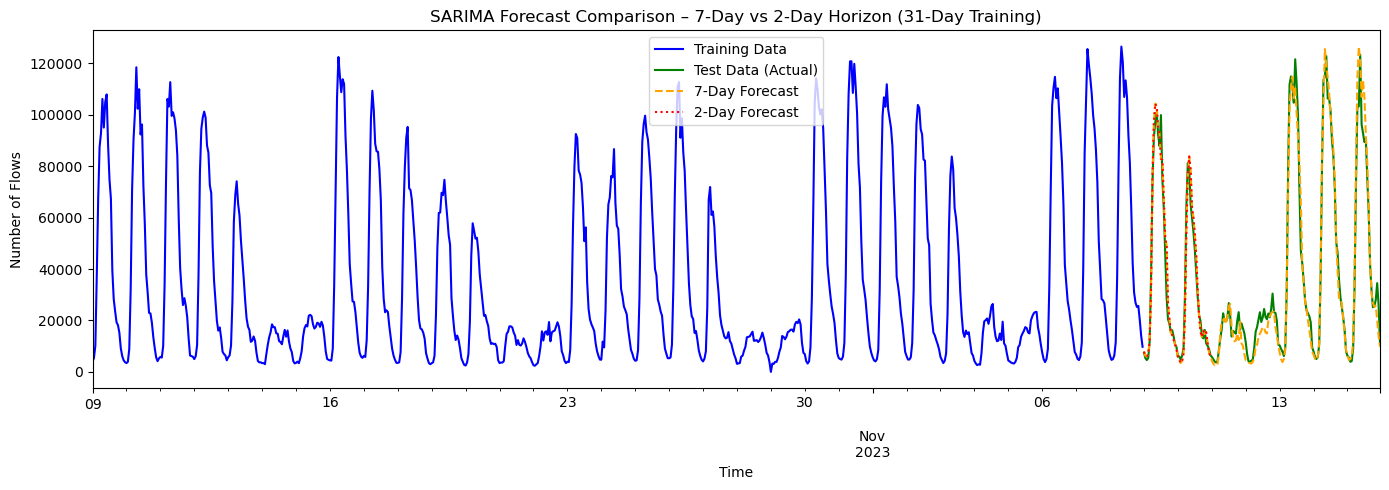


 Forecast Evaluation (One-shot SARIMA – 7 Days):
RMSE:  5986.68 flows/hour
MAE:   4134.22 flows/hour
SMAPE: 17.39%
R²:    0.971

 Forecast Evaluation (One-shot SARIMA – 2 Days):
RMSE:  5694.00 flows/hour
MAE:   3889.39 flows/hour
SMAPE: 13.46%
R²:    0.968


In [14]:
order = (1, 0, 0)
seasonal_order = (0, 1, 0, 168)
train_window = 24 * 31  # 744 hours ≈ 1 month
forecast_horizon_7d = 24 * 7  # 168 hours = 7 days
forecast_horizon_2d = 24 * 2  # 48 hours = 2 days

# Ensure DataFrame is sorted by time
df = df.sort_index()

# ------------------
# 7-DAY FORECAST
# ------------------
train_series_7d = df['n_flows'].iloc[:train_window]
test_series_7d = df['n_flows'].iloc[train_window:train_window + forecast_horizon_7d]

sarima_model_7d = SARIMAX(train_series_7d, order=order, seasonal_order=seasonal_order)
sarima_result_7d = sarima_model_7d.fit(disp=False)

forecast_7d = sarima_result_7d.forecast(steps=forecast_horizon_7d)
forecast_7d.index = test_series_7d.index  # Align with actual

# ------------------
# 2-DAY FORECAST 
# ------------------
train_series_2d = df['n_flows'].iloc[:train_window]
test_series_2d = df['n_flows'].iloc[train_window:train_window + forecast_horizon_2d]

sarima_model_2d = SARIMAX(train_series_2d, order=order, seasonal_order=seasonal_order)
sarima_result_2d = sarima_model_2d.fit(disp=False)

forecast_2d = sarima_result_2d.forecast(steps=forecast_horizon_2d)
forecast_2d.index = test_series_2d.index

# ------------------
# PLOT COMPARISON
# ------------------
plt.figure(figsize=(14, 5))
train_series_7d.plot(label="Training Data", color='blue')
test_series_7d.plot(label="Test Data (Actual)", color='green')
forecast_7d.plot(label="7-Day Forecast", color='orange', linestyle='--')
forecast_2d.plot(label="2-Day Forecast", color='red', linestyle=':')

plt.title("SARIMA Forecast Comparison – 7-Day vs 2-Day Horizon (31-Day Training)")
plt.xlabel("Time")
plt.ylabel("Number of Flows")
plt.legend()
plt.tight_layout()
plt.savefig("SARIMA Forecast II 7Days vs 2 Days.png", dpi=300, bbox_inches='tight')
plt.show()

# ------------------
# Evaluation 
# ------------------
def print_metrics(y_true, y_pred, label):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    smape = 100 * np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))
    r2 = r2_score(y_true, y_pred)
    print(f"\n Forecast Evaluation ({label}):")
    print(f"RMSE:  {rmse:.2f} flows/hour")
    print(f"MAE:   {mae:.2f} flows/hour")
    print(f"SMAPE: {smape:.2f}%")
    print(f"R²:    {r2:.3f}")

print_metrics(test_series_7d, forecast_7d, "One-shot SARIMA – 7 Days")
print_metrics(test_series_2d, forecast_2d, "One-shot SARIMA – 2 Days")

================================ 4. One-shot SARIMA forecast II Anomaly Detection (7 Days and 2 Days) ================================

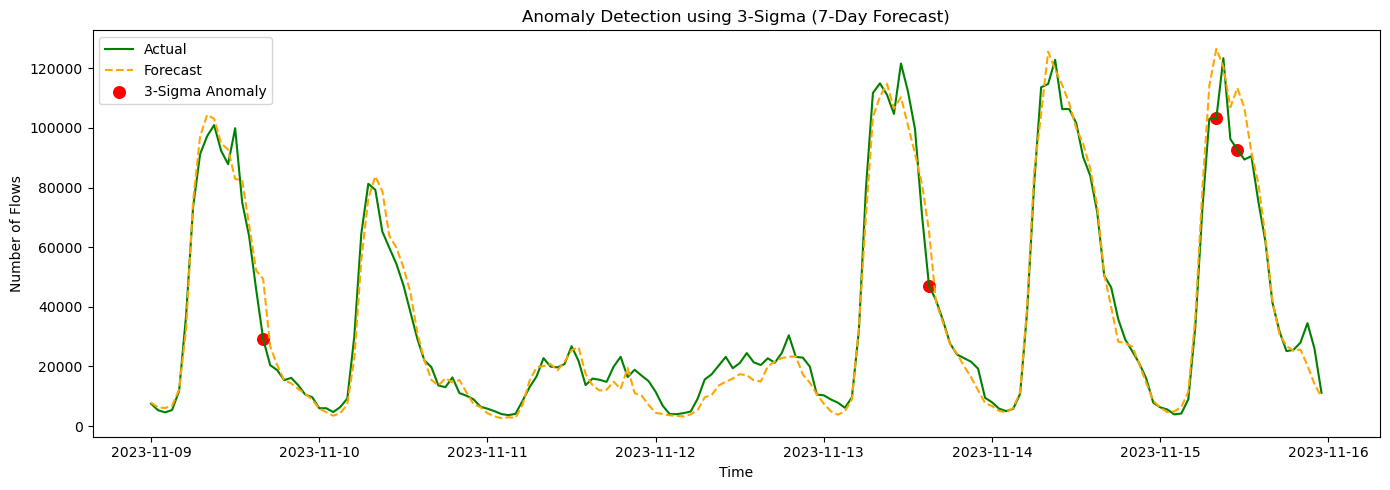

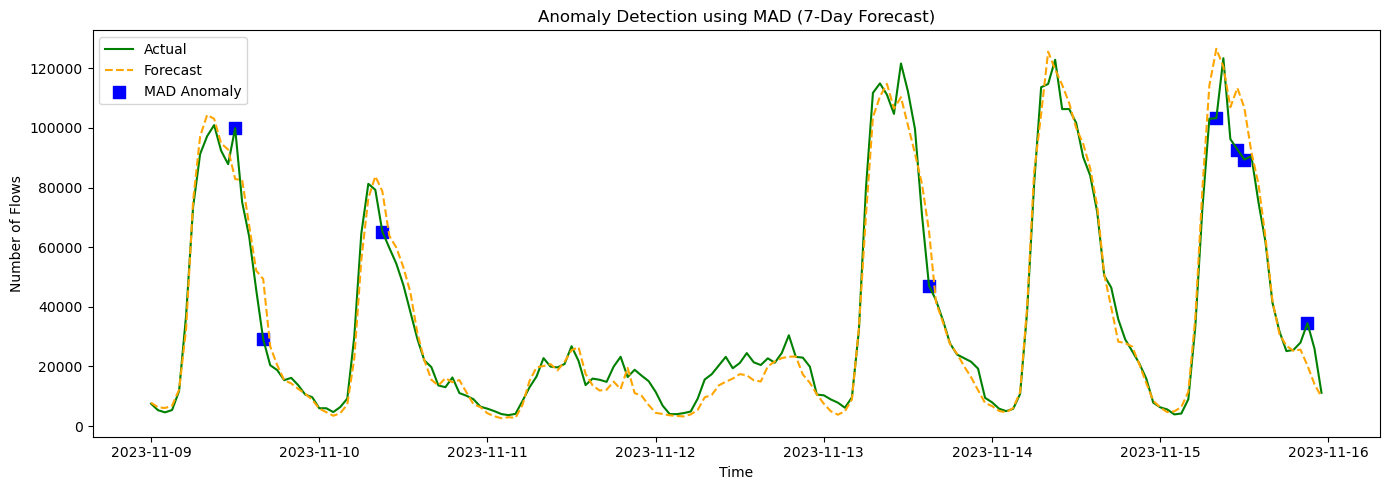

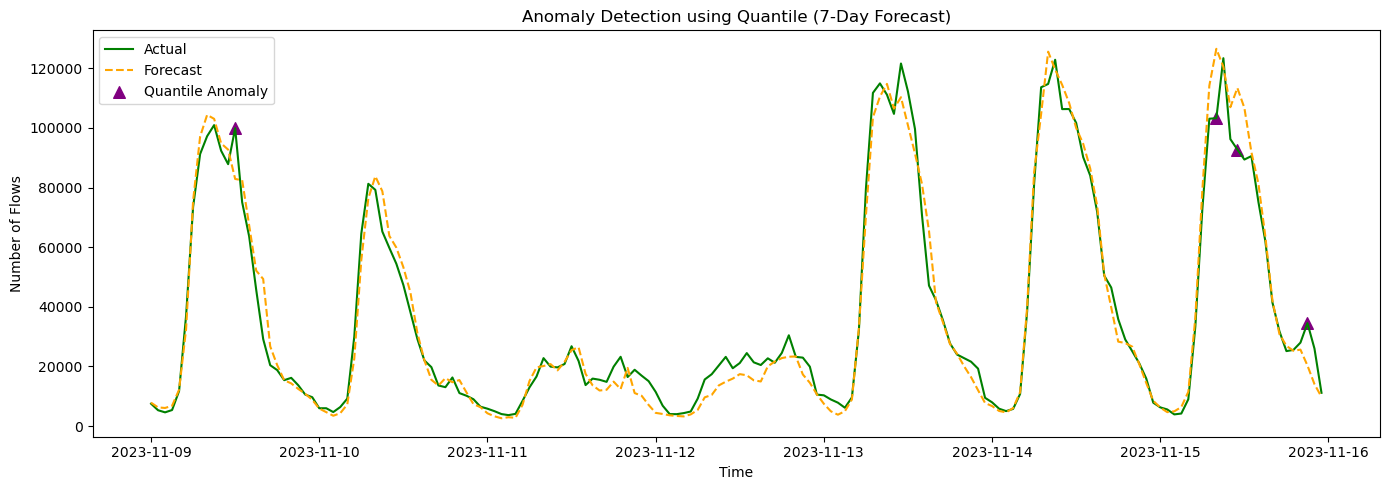

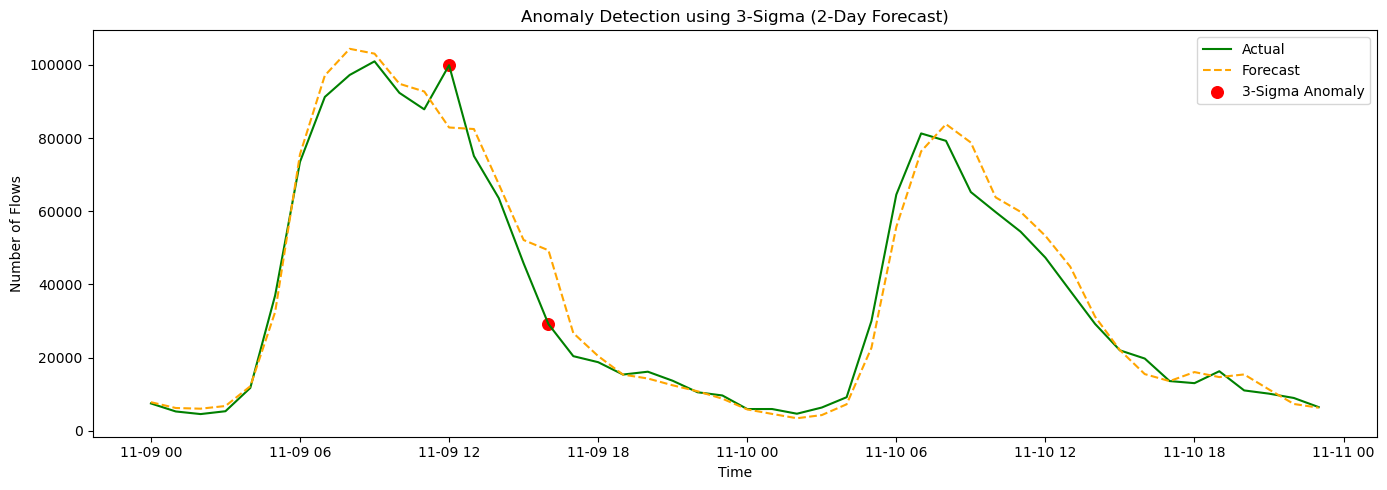

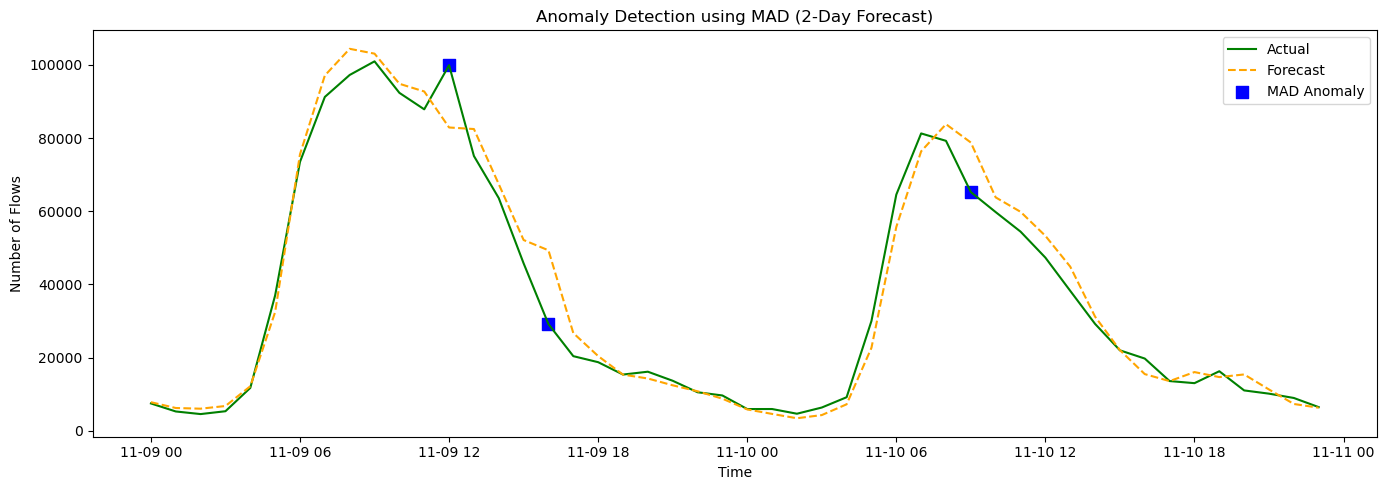

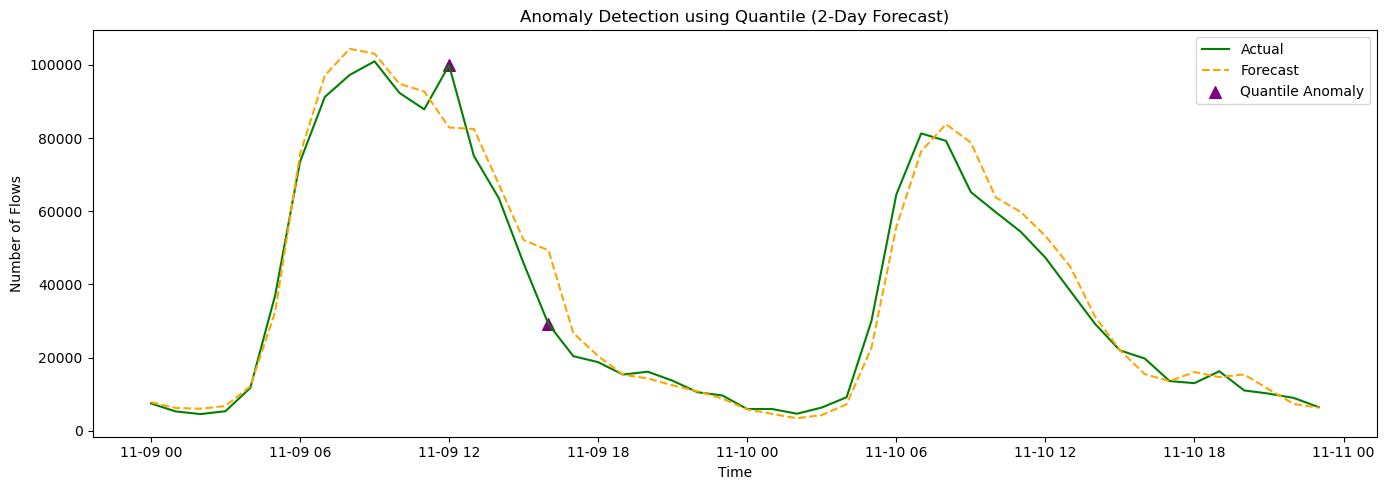


 Anomaly Detection Summary Table:
  Method  7-Day Anomalies  2-Day Anomalies
 3-Sigma                4                2
     MAD                8                3
Quantile                4                2


In [15]:
 #--------- ANOMALY DETECTION FUNCTION ---------
def detect_anomalies(residuals):
    # 3-Sigma
    res_mean = residuals.mean()
    res_std = residuals.std()
    anomalies_3sigma = (residuals > res_mean + 3 * res_std) | (residuals < res_mean - 3 * res_std)

    # MAD
    med = residuals.median()
    mad = np.median(np.abs(residuals - med))
    mad_scaled = 1.4826 * mad
    anomalies_mad = (residuals > med + 3 * mad_scaled) | (residuals < med - 3 * mad_scaled)

    # Quantile
    q_lo = residuals.quantile(0.01)
    q_hi = residuals.quantile(0.99)
    anomalies_quant = (residuals < q_lo) | (residuals > q_hi)

    return anomalies_3sigma, anomalies_mad, anomalies_quant


# Create a folder to save plots
output_dir = "anomaly_plots"
os.makedirs(output_dir, exist_ok=True)

# --------- PLOTTING FUNCTION ---------
def plot_anomaly_method(series, forecast, anomaly_mask, method_name, color, marker, label, filename):
    series = series.copy()
    forecast = forecast.copy()
    anomaly_mask = anomaly_mask.reindex(series.index, fill_value=False)

    plt.figure(figsize=(14, 5))
    plt.plot(series.index, series, label='Actual', color='green')
    plt.plot(forecast.index, forecast, label='Forecast', color='orange', linestyle='--')
    plt.scatter(series.index[anomaly_mask], series[anomaly_mask],
                color=color, s=70, marker=marker, label=f'{method_name} Anomaly')
    plt.title(f'Anomaly Detection using {method_name} ({label})')
    plt.xlabel("Time")
    plt.ylabel("Number of Flows")
    plt.legend()
    plt.tight_layout()

    # Save and then show the plot
    plt.savefig(os.path.join(output_dir, filename), dpi=300)
    plt.show()

# --------- 7-DAY FORECAST ANOMALY DETECTION ---------
residuals_7d = test_series_7d - forecast_7d
anomalies_3sigma_7d, anomalies_mad_7d, anomalies_quant_7d = detect_anomalies(residuals_7d)

# Align indices
anomalies_3sigma_7d.index = test_series_7d.index
anomalies_mad_7d.index = test_series_7d.index
anomalies_quant_7d.index = test_series_7d.index

# Plot and save
plot_anomaly_method(test_series_7d, forecast_7d, anomalies_3sigma_7d, "3-Sigma", 'red', 'o', "7-Day Forecast", "7day_3sigma.png")
plot_anomaly_method(test_series_7d, forecast_7d, anomalies_mad_7d, "MAD", 'blue', 's', "7-Day Forecast", "7day_mad.png")
plot_anomaly_method(test_series_7d, forecast_7d, anomalies_quant_7d, "Quantile", 'purple', '^', "7-Day Forecast", "7day_quantile.png")

# --------- 2-DAY FORECAST ANOMALY DETECTION ---------
residuals_2d = test_series_2d - forecast_2d
anomalies_3sigma_2d, anomalies_mad_2d, anomalies_quant_2d = detect_anomalies(residuals_2d)

# Align indices
anomalies_3sigma_2d.index = test_series_2d.index
anomalies_mad_2d.index = test_series_2d.index
anomalies_quant_2d.index = test_series_2d.index

# Plot and save
plot_anomaly_method(test_series_2d, forecast_2d, anomalies_3sigma_2d, "3-Sigma", 'red', 'o', "2-Day Forecast", "2day_3sigma.png")
plot_anomaly_method(test_series_2d, forecast_2d, anomalies_mad_2d, "MAD", 'blue', 's', "2-Day Forecast", "2day_mad.png")
plot_anomaly_method(test_series_2d, forecast_2d, anomalies_quant_2d, "Quantile", 'purple', '^', "2-Day Forecast", "2day_quantile.png")

# --------- SUMMARY TABLE ---------

anomaly_summary = pd.DataFrame({
    "Method": ["3-Sigma", "MAD", "Quantile"],
    "7-Day Anomalies": [
        anomalies_3sigma_7d.sum(),
        anomalies_mad_7d.sum(),
        anomalies_quant_7d.sum()
    ],
    "2-Day Anomalies": [
        anomalies_3sigma_2d.sum(),
        anomalies_mad_2d.sum(),
        anomalies_quant_2d.sum()
    ]
})

print("\n Anomaly Detection Summary Table:")
print(anomaly_summary.to_string(index=False))

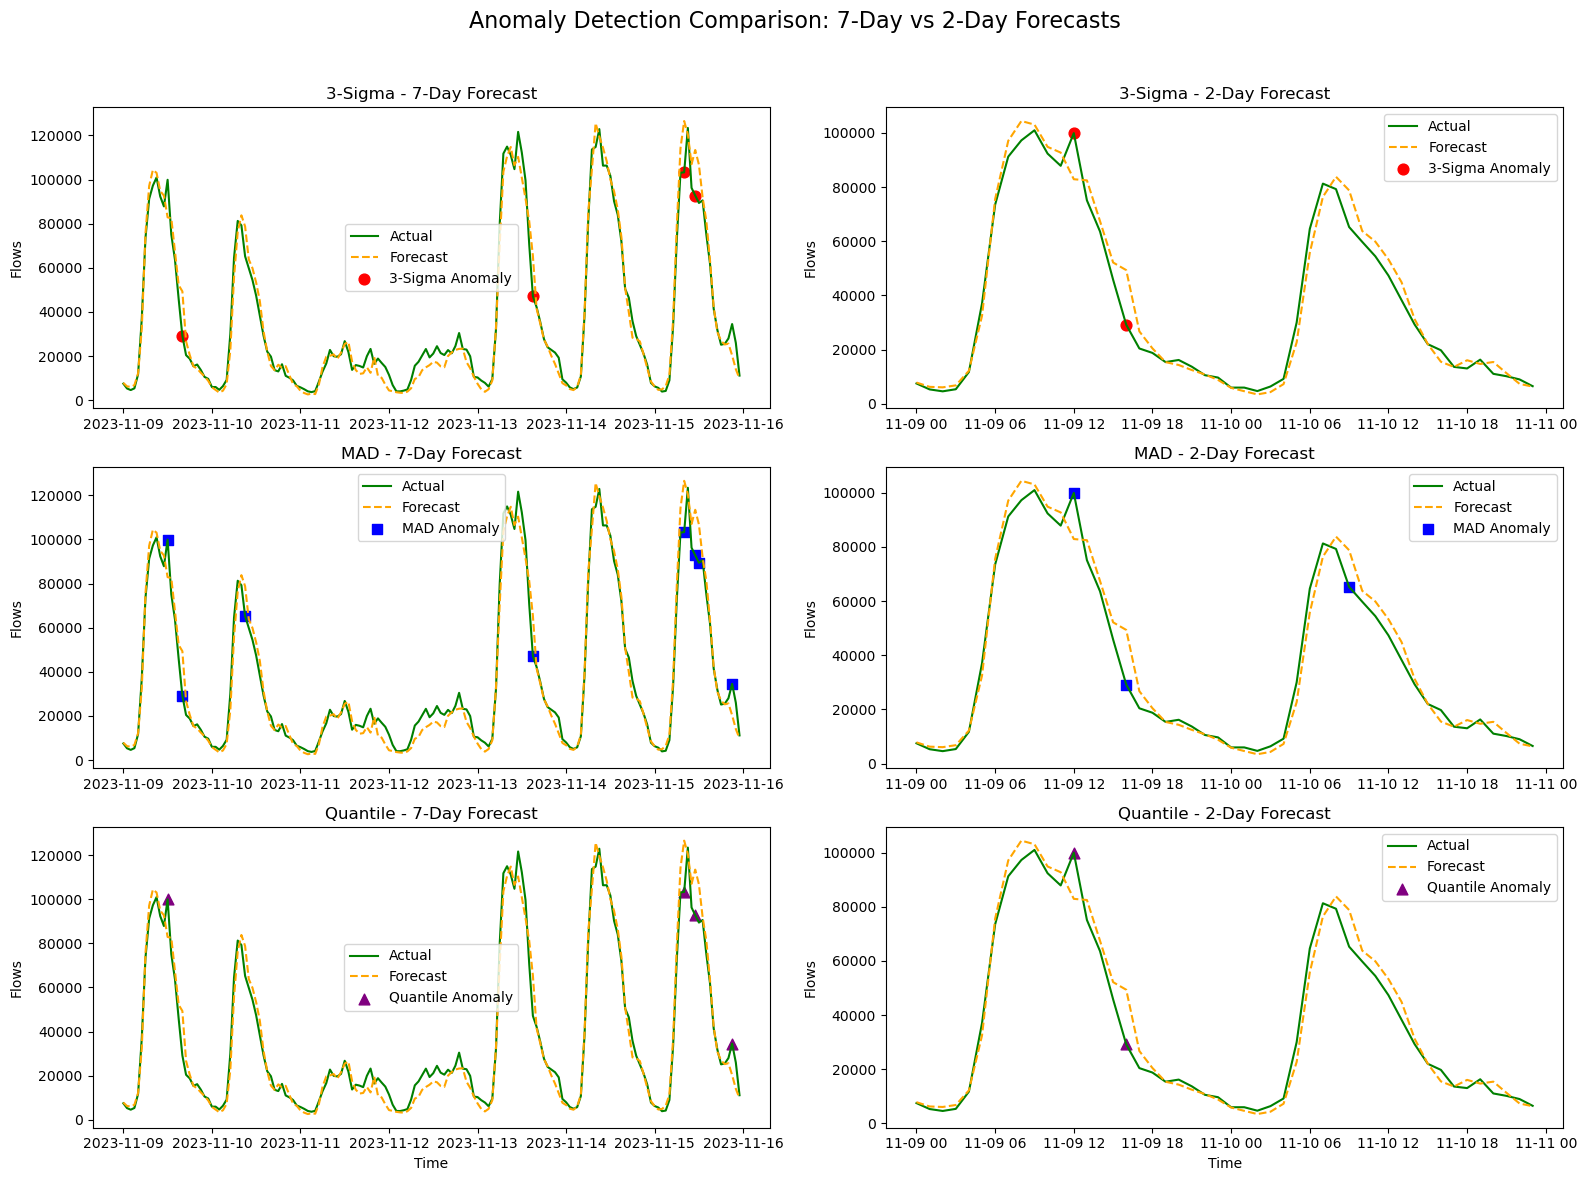

In [18]:
# Set up 3 rows (methods) × 2 columns (7-day vs 2-day)
fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex=False)

methods = ["3-Sigma", "MAD", "Quantile"]
colors = ["red", "blue", "purple"]
markers = ["o", "s", "^"]

anomaly_sets = [
    (anomalies_3sigma_7d, anomalies_3sigma_2d),
    (anomalies_mad_7d, anomalies_mad_2d),
    (anomalies_quant_7d, anomalies_quant_2d)
]

# Loop through methods and plot
for i, (method, color, marker) in enumerate(zip(methods, colors, markers)):
    # 7-Day Forecast subplot
    axes[i, 0].plot(test_series_7d.index, test_series_7d, label='Actual', color='green')
    axes[i, 0].plot(forecast_7d.index, forecast_7d, label='Forecast', color='orange', linestyle='--')
    axes[i, 0].scatter(test_series_7d.index[anomaly_sets[i][0]], test_series_7d[anomaly_sets[i][0]],
                      color=color, s=60, marker=marker, label=f'{method} Anomaly')
    axes[i, 0].set_title(f"{method} - 7-Day Forecast")
    axes[i, 0].set_ylabel("Flows")
    axes[i, 0].legend()

    # 2-Day Forecast subplot
    axes[i, 1].plot(test_series_2d.index, test_series_2d, label='Actual', color='green')
    axes[i, 1].plot(forecast_2d.index, forecast_2d, label='Forecast', color='orange', linestyle='--')
    axes[i, 1].scatter(test_series_2d.index[anomaly_sets[i][1]], test_series_2d[anomaly_sets[i][1]],
                      color=color, s=60, marker=marker, label=f'{method} Anomaly')
    axes[i, 1].set_title(f"{method} - 2-Day Forecast")
    axes[i, 1].set_ylabel("Flows")
    axes[i, 1].legend()

# Common X label
for ax in axes[2]:
    ax.set_xlabel("Time")

plt.suptitle("Anomaly Detection Comparison: 7-Day vs 2-Day Forecasts", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("anomaly_detection_7d_2d_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


###### ================================ 5. One-shot SARIMA forecast II (2 days) ================================

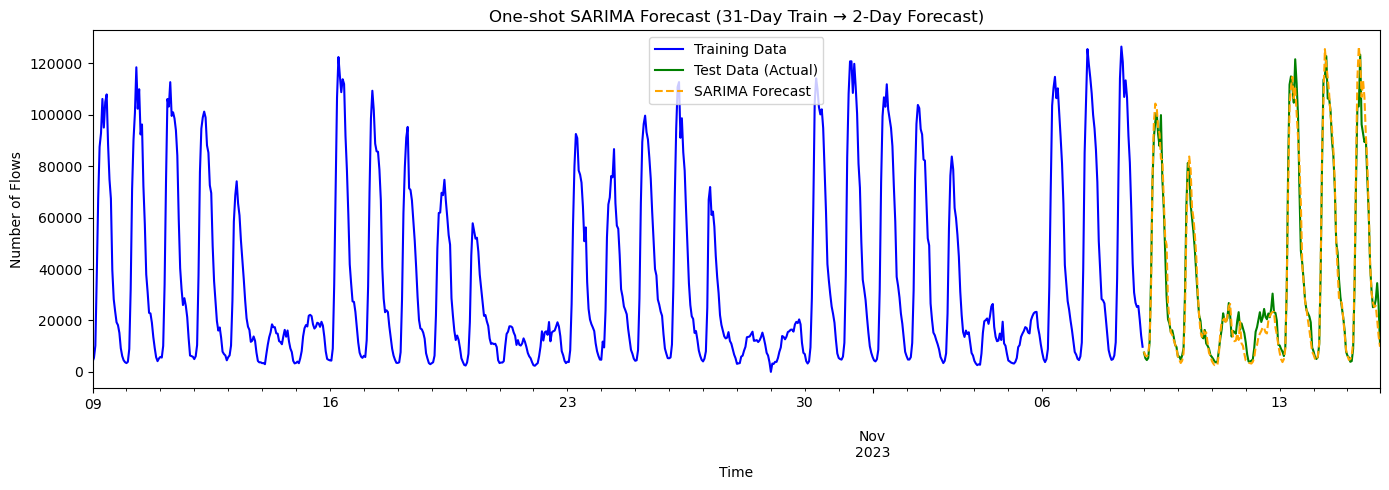

📈 Forecast Evaluation (One-shot SARIMA):
RMSE:  5986.68 flows/hour
MAE:   4134.22 flows/hour
SMAPE: 17.39%
R²:    0.971


In [9]:
order = (1, 0, 0)
seasonal_order = (0, 1, 0, 168)
train_window = 24 * 31  # 744 hours ≈ 1 month
forecast_horizon = 24 * 7 # 48 hours = 2 days

# Ensure DataFrame is sorted by time
df = df.sort_index()

# Define train and test slices
train_series = df['n_flows'].iloc[:train_window]
test_series = df['n_flows'].iloc[train_window:train_window + forecast_horizon]

# Fit SARIMA on training data
sarima_model = SARIMAX(train_series, order=order, seasonal_order=seasonal_order)
sarima_result = sarima_model.fit(disp=False)

# Forecast the next 7 days
forecast = sarima_result.forecast(steps=forecast_horizon)
forecast.index = test_series.index  # Align forecast with actual

# Plot forecast vs actual
plt.figure(figsize=(14, 5))
train_series.plot(label="Training Data", color='blue')
test_series.plot(label="Test Data (Actual)", color='green')
forecast.plot(label="SARIMA Forecast", color='orange', linestyle='--')

plt.title("One-shot SARIMA Forecast (31-Day Train → 2-Day Forecast)")
plt.xlabel("Time")
plt.ylabel("Number of Flows")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate forecast
rmse = np.sqrt(mean_squared_error(test_series, forecast))
mae = mean_absolute_error(test_series, forecast)
r2 = r2_score(test_series, forecast)

# Compute SMAPE 
numerator = np.abs(test_series - forecast)
denominator = (np.abs(test_series) + np.abs(forecast)) / 2
smape = 100 * np.mean(np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0))

print("📈 Forecast Evaluation (One-shot SARIMA):")
print(f"RMSE:  {rmse:.2f} flows/hour")
print(f"MAE:   {mae:.2f} flows/hour")
print(f"SMAPE: {smape:.2f}%")
print(f"R²:    {r2:.3f}")

C:\Users\sabid\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.000
Recall:    0.000
F1-Score:  0.000


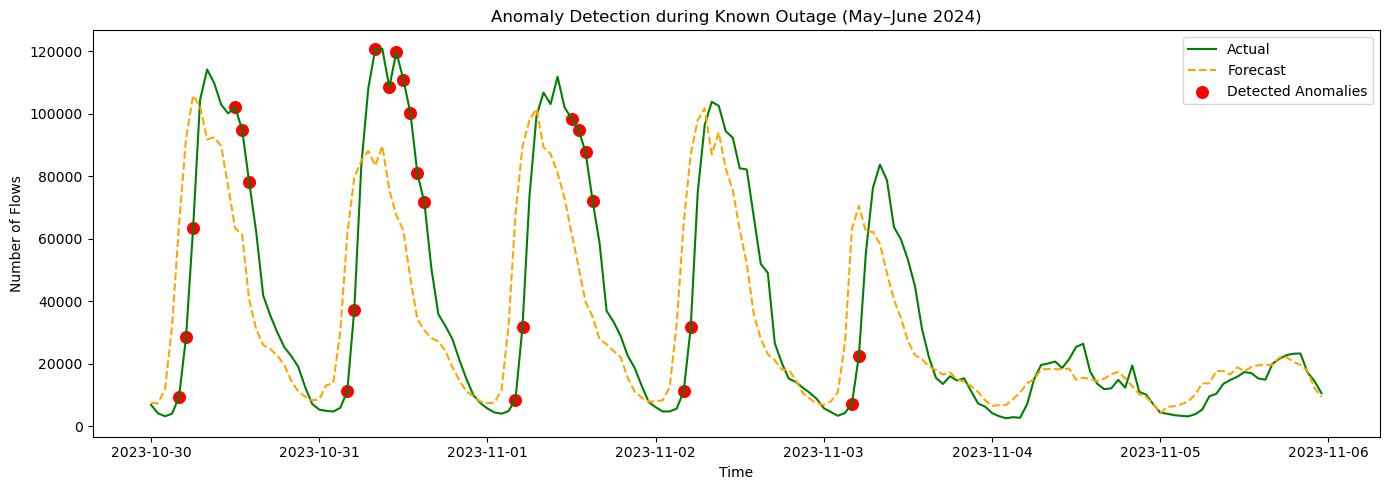

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate residuals
residuals = test_series - forecast

# Compute 3-sigma thresholds
# MAD Detection
med = residuals.median()
mad = np.median(np.abs(residuals - med))
mad_scaled = 1.4826 * mad
anomalies = (residuals > med + 3 * mad_scaled) | (residuals < med - 3 * mad_scaled)

# Define the known anomaly period
anomaly_start = pd.Timestamp("2024-05-21 00:00:00", tz='UTC')
anomaly_end = pd.Timestamp("2024-06-04 23:00:00", tz='UTC')

# Create ground truth labels
ground_truth = pd.Series(0, index=test_series.index)
ground_truth[(test_series.index >= anomaly_start) & (test_series.index <= anomaly_end)] = 1
# Calculate evaluation metrics
precision = precision_score(ground_truth, anomalies)
recall = recall_score(ground_truth, anomalies)
f1 = f1_score(ground_truth, anomalies)

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-Score:  {f1:.3f}")
plt.figure(figsize=(14, 5))
plt.plot(test_series.index, test_series, label='Actual', color='green')
plt.plot(forecast.index, forecast, label='Forecast', color='orange', linestyle='--')
plt.scatter(test_series.index[anomalies == 1], test_series[anomalies == 1],
            color='red', s=70, marker='o', label='Detected Anomalies')
plt.title("Anomaly Detection during Known Outage (May–June 2024)")
plt.xlabel("Time")
plt.ylabel("Number of Flows")
plt.legend()
plt.tight_layout()
plt.savefig("anomaly_known_window.png", dpi=300)
plt.show()

###### ================================ 6. One-shot SARIMA forecast II (2 days) Anomaly Detection ================================

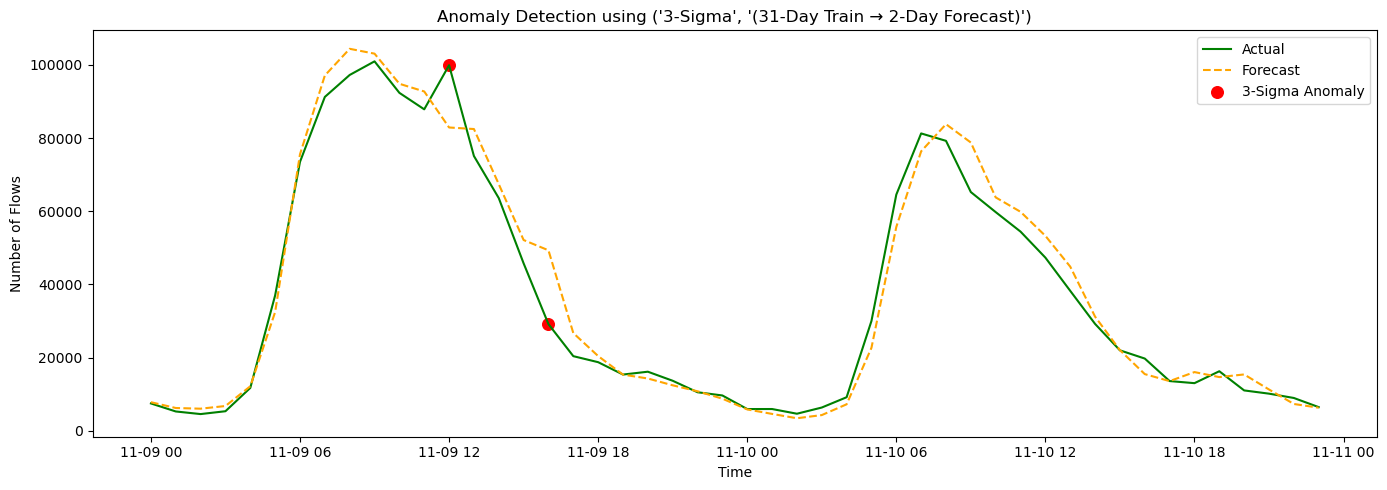

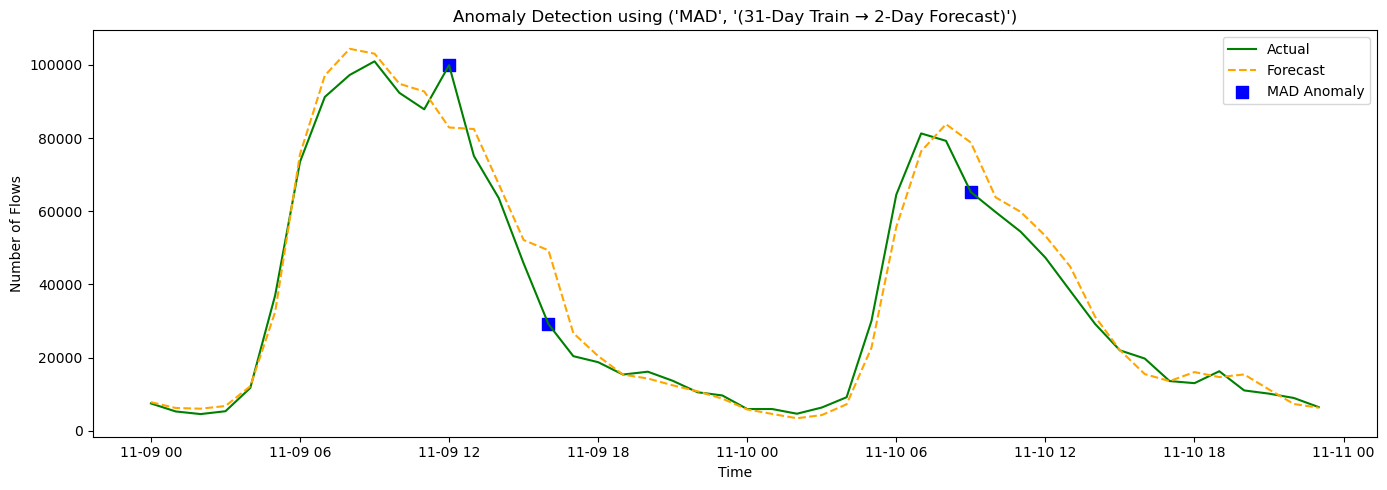

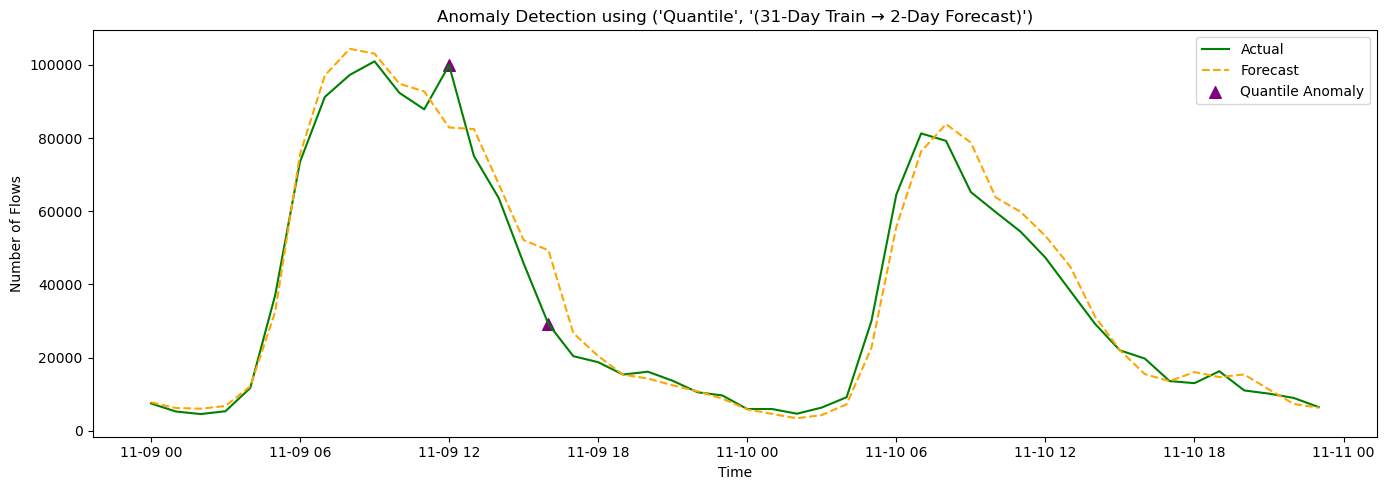

Anomalies Detected in Test Period:
• 3-Sigma method      : 2 points
• MAD method          : 3 points
• Quantile method     : 2 points


In [20]:
# Residuals (168 values) 
#forecast.index = test_series.index
residuals = test_series - forecast

# 3-Sigma Detection
res_mean = residuals.mean()
res_std = residuals.std()
anomalies_3sigma = (residuals > res_mean + 3 * res_std) | (residuals < res_mean - 3 * res_std)

# MAD Detection
med = residuals.median()
mad = np.median(np.abs(residuals - med))
mad_scaled = 1.4826 * mad
anomalies_mad = (residuals > med + 3 * mad_scaled) | (residuals < med - 3 * mad_scaled)

# Quantile Detection
q_lo = residuals.quantile(0.01)
q_hi = residuals.quantile(0.99)
anomalies_quant = (residuals < q_lo) | (residuals > q_hi)

# Align all masks to test_series.index
anomalies_3sigma.index = test_series.index
anomalies_mad.index = test_series.index
anomalies_quant.index = test_series.index
def plot_anomaly_method(series, forecast, anomaly_mask, method_name, color, marker):
    series = series.copy()
    forecast = forecast.copy()
    anomaly_mask = anomaly_mask.reindex(series.index, fill_value=False)  # align by index
    
    plt.figure(figsize=(14, 5))
    plt.plot(series.index, series, label='Actual', color='green')
    plt.plot(forecast.index, forecast, label='Forecast', color='orange', linestyle='--')
    plt.scatter(series.index[anomaly_mask], series[anomaly_mask],
                color=color, s=70, marker=marker, label=f'{method_name} Anomaly')
    plt.title(f'Anomaly Detection using {method_name, "(31-Day Train → 2-Day Forecast)"}')
    plt.xlabel("Time")
    plt.ylabel("Number of Flows")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call for each
plot_anomaly_method(test_series, forecast, anomalies_3sigma, "3-Sigma", 'red', 'o')
plot_anomaly_method(test_series, forecast, anomalies_mad, "MAD", 'blue', 's')
plot_anomaly_method(test_series, forecast, anomalies_quant, "Quantile", 'purple', '^')
print("Anomalies Detected in Test Period:")
print(f"• 3-Sigma method      : {anomalies_3sigma.sum()} points")
print(f"• MAD method          : {anomalies_mad.sum()} points")
print(f"• Quantile method     : {anomalies_quant.sum()} points")

###### ================================ 4. Rolling Forecasting with SARIMA  for 7 Days================================

We perform rolling forecasting in a retraining loop to simulate ongoing monitoring. The procedure is as follows: use a sliding training window of 720 hours (30 days) of past data to fit the SARIMA model, then forecast the next 168 hours (7 days) ahead. Then advance the window by 168 hours (one week), incorporate the new actual data, re-fit the model on the most recent 30 days, and forecast the next week. We repeat this weekly retraining and forecasting through the entire 40-week span, collecting the forecasts and actual values for each 7-day prediction window. In this way, the model is always trained on the most recent month of data and updated every week, which helps it adapt to any slowly changing patterns while still using a consistent amount of history.


 Forecast Evaluation: Rolling SARIMA 7 Days(Last 5 Weeks)
RMSE:  6948.49 flows/hour
MAE:   4155.93 flows/hour
R²:    0.414
SMAPE: 51.04%


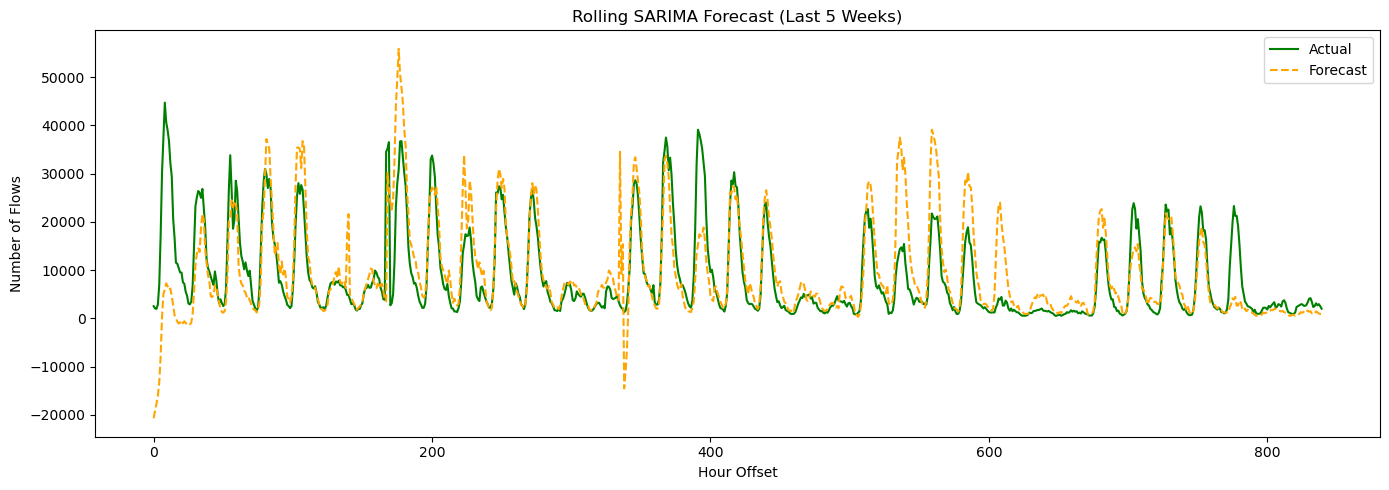

In [9]:
# Parameters
order = (1, 0, 0)
seasonal_order = (0, 1, 0, 168)
train_window = 24 * 31      # 720 hours = 30 days
forecast_horizon = 24 * 7    # 168 hours = 7 days

# Containers
predictions = []
actuals = []

# Rolling forecast on last 5 weeks
for start in range(len(df) - 5 * forecast_horizon, len(df) - forecast_horizon + 1, forecast_horizon):
    # Select 30-day training window
    train_series = df['n_flows'].iloc[start - train_window : start]

    # Fit SARIMA model
    model = SARIMAX(train_series, order=order, seasonal_order=seasonal_order)
    result = model.fit(disp=False, maxiter=50)

    # Forecast next 7 days
    forecast = result.forecast(steps=forecast_horizon)

    # Store predictions and actuals
    predictions.extend(forecast.values)
    actual = df['n_flows'].iloc[start : start + forecast_horizon]
    actuals.extend(actual.values)

# Convert to arrays
predictions = np.array(predictions)
actuals = np.array(actuals)

# Evaluation
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
numerator = np.abs(actuals - predictions)
denominator = (np.abs(actuals) + np.abs(predictions)) / 2
smape = 100 * np.mean(np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0))

print("\n Forecast Evaluation: Rolling SARIMA 7 Days(Last 5 Weeks)")

print(f"RMSE:  {rmse:.2f} flows/hour")
print(f"MAE:   {mae:.2f} flows/hour")
print(f"R²:    {r2:.3f}")
print(f"SMAPE: {smape:.2f}%")

# Plot
plt.figure(figsize=(14, 5))
plt.plot(actuals, label="Actual", color='green')
plt.plot(predictions, label="Forecast", color='orange', linestyle='--')
plt.title("Rolling SARIMA Forecast (Last 5 Weeks)")
plt.xlabel("Hour Offset")
plt.ylabel("Number of Flows")
plt.legend()
plt.tight_layout()
plt.savefig("Rolling SARIMA II 7Days.png", dpi=300, bbox_inches='tight')
plt.show()


 Forecast Evaluation: Rolling SARIMA (Last 5 Weeks and for 2 Days)
RMSE:  4619.42 flows/hour
MAE:   2719.66 flows/hour
R²:    0.451
SMAPE: 62.46%


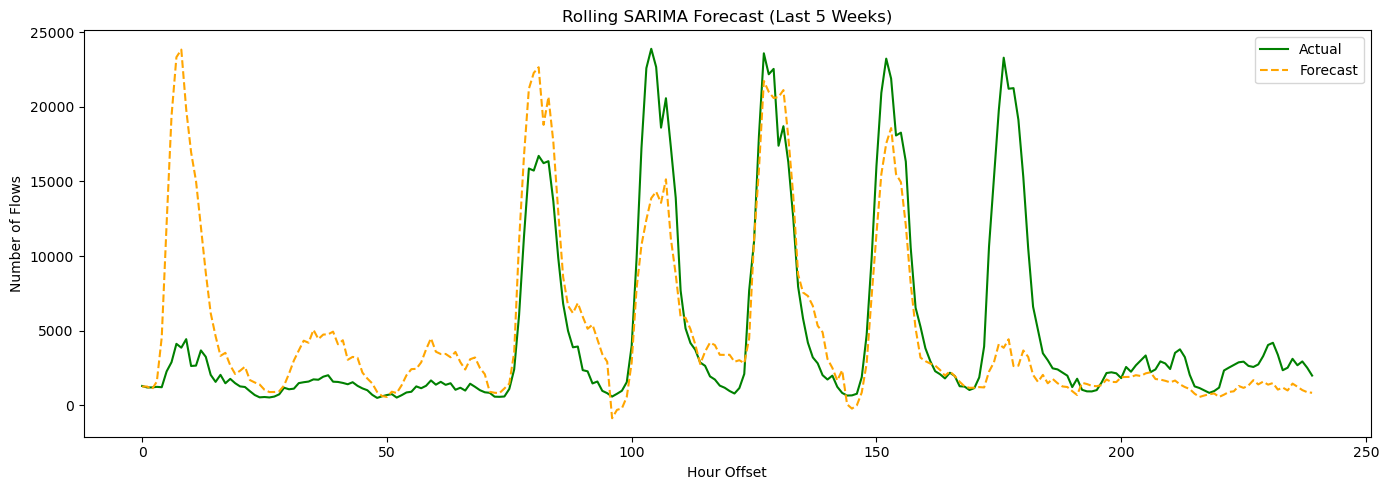

In [10]:
# Parameters
order = (1, 0, 0)
seasonal_order = (0, 1, 0, 168)
train_window = 24 * 31     # 720 hours = 30 days
forecast_horizon = 24 * 2    # 168 hours = 7 days

# Containers
predictions = []
actuals = []

# Rolling forecast on last 5 weeks
for start in range(len(df) - 5 * forecast_horizon, len(df) - forecast_horizon + 1, forecast_horizon):
    # Select 30-day training window
    train_series = df['n_flows'].iloc[start - train_window : start]

    # Fit SARIMA model
    model = SARIMAX(train_series, order=order, seasonal_order=seasonal_order)
    result = model.fit(disp=False)

    # Forecast next 7 days
    forecast = result.forecast(steps=forecast_horizon)

    # Store predictions and actuals
    predictions.extend(forecast.values)
    actual = df['n_flows'].iloc[start : start + forecast_horizon]
    actuals.extend(actual.values)

# Convert to arrays
predictions = np.array(predictions)
actuals = np.array(actuals)

# Evaluation
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
numerator = np.abs(actuals - predictions)
denominator = (np.abs(actuals) + np.abs(predictions)) / 2
smape = 100 * np.mean(np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0))

print("\n Forecast Evaluation: Rolling SARIMA (Last 5 Weeks and for 2 Days)")
print(f"RMSE:  {rmse:.2f} flows/hour")
print(f"MAE:   {mae:.2f} flows/hour")
print(f"R²:    {r2:.3f}")
print(f"SMAPE: {smape:.2f}%")

# Plot
plt.figure(figsize=(14, 5))
plt.plot(actuals, label="Actual", color='green')
plt.plot(predictions, label="Forecast", color='orange', linestyle='--')
plt.title("Rolling SARIMA Forecast (Last 5 Weeks)")
plt.xlabel("Hour Offset")
plt.ylabel("Number of Flows")
plt.legend()
plt.tight_layout()
plt.savefig("SARIMA Rolling Forecast 2 Days.png", dpi=300, bbox_inches='tight')
plt.show()


 Forecast Evaluation: Rolling SARIMA (Last 5 Weeks and for 7 Days)
RMSE:  6948.49 flows/hour
MAE:   4155.93 flows/hour
R²:    0.414
SMAPE: 51.04%


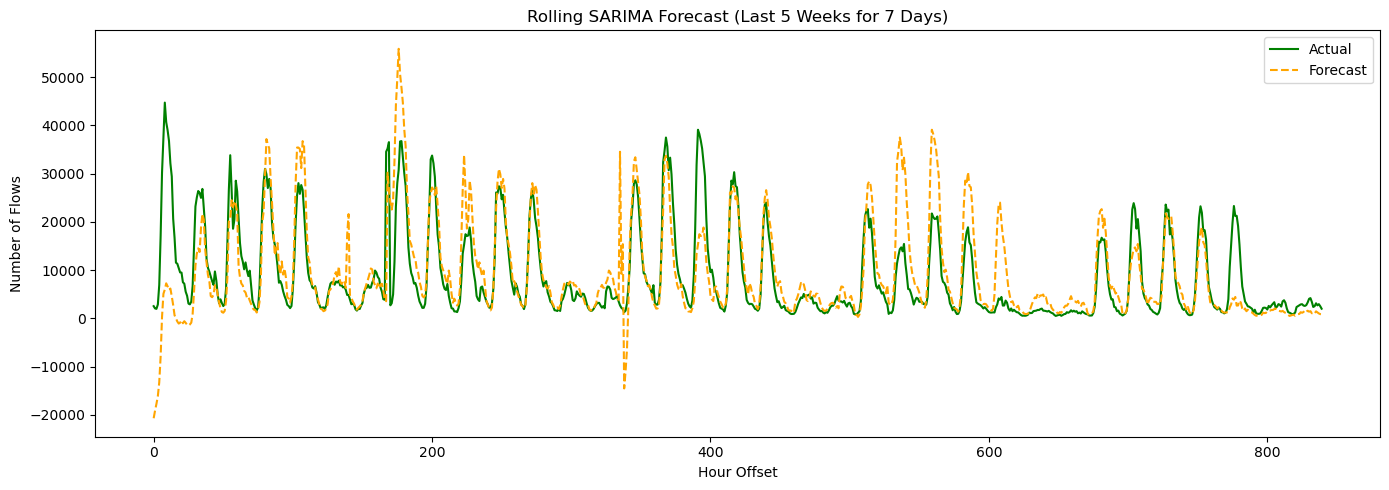

In [11]:
# Parameters
order = (1, 0, 0)
seasonal_order = (0, 1, 0, 168)
train_window = 24 * 31     # 720 hours = 30 days
forecast_horizon = 24 * 7    # 168 hours = 7 days

# Containers
predictions = []
actuals = []

# Rolling forecast on last 5 weeks
for start in range(len(df) - 5 * forecast_horizon, len(df) - forecast_horizon + 1, forecast_horizon):
    # Select 30-day training window
    train_series = df['n_flows'].iloc[start - train_window : start]

    # Fit SARIMA model
    model = SARIMAX(train_series, order=order, seasonal_order=seasonal_order)
    result = model.fit(disp=False)

    # Forecast next 7 days
    forecast = result.forecast(steps=forecast_horizon)

    # Store predictions and actuals
    predictions.extend(forecast.values)
    actual = df['n_flows'].iloc[start : start + forecast_horizon]
    actuals.extend(actual.values)

# Convert to arrays
predictions = np.array(predictions)
actuals = np.array(actuals)

# Evaluation
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
numerator = np.abs(actuals - predictions)
denominator = (np.abs(actuals) + np.abs(predictions)) / 2
smape = 100 * np.mean(np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0))

print("\n Forecast Evaluation: Rolling SARIMA (Last 5 Weeks and for 7 Days)")
print(f"RMSE:  {rmse:.2f} flows/hour")
print(f"MAE:   {mae:.2f} flows/hour")
print(f"R²:    {r2:.3f}")
print(f"SMAPE: {smape:.2f}%")

# Plot
plt.figure(figsize=(14, 5))
plt.plot(actuals, label="Actual", color='green')
plt.plot(predictions, label="Forecast", color='orange', linestyle='--')
plt.title("Rolling SARIMA Forecast (Last 5 Weeks for 7 Days)")
plt.xlabel("Hour Offset")
plt.ylabel("Number of Flows")
plt.legend()
plt.tight_layout()
plt.savefig("SARIMA Rolling Forecast 7 Days.png", dpi=300, bbox_inches='tight')
plt.show()


In [6]:
# Parameters
order = (1, 0, 0)
seasonal_order = (0, 1, 0, 168)
train_window = 24 * 31      # 744 hours = 31 days
forecast_horizon = 24 * 7   # 168 hours = 7 days

# Containers
predictions = []
actuals = []
timestamps = []

# Rolling forecast on full dataset
for start in range(train_window, len(df) - forecast_horizon + 1, forecast_horizon):
    # Select training window
    train_series = df['n_flows'].iloc[start - train_window : start]

    # Fit SARIMA model
    model = SARIMAX(train_series, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit(disp=False, maxiter=50)

    # Forecast next 7 days
    forecast = result.forecast(steps=forecast_horizon)

    # Store actuals, predictions, and timestamps
    test_slice = df['n_flows'].iloc[start : start + forecast_horizon]
    predictions.extend(forecast.values)
    actuals.extend(test_slice.values)
    timestamps.extend(test_slice.index)

# Convert to pandas Series with proper datetime index
predictions = pd.Series(predictions, index=timestamps)
actuals = pd.Series(actuals, index=timestamps)

# Evaluation
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
numerator = np.abs(actuals - predictions)
denominator = (np.abs(actuals) + np.abs(predictions)) / 2
smape = 100 * np.mean(np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0))

print("\n Forecast Evaluation: Rolling SARIMA (Full Period)")
print(f"RMSE:  {rmse:.2f} flows/hour")
print(f"MAE:   {mae:.2f} flows/hour")
print(f"R²:    {r2:.3f}")
print(f"SMAPE: {smape:.2f}%")

# Plot with proper date axis
plt.figure(figsize=(14, 5))
plt.plot(actuals.index, actuals, label="Actual", color='green')
plt.plot(predictions.index, predictions, label="Forecast", color='orange', linestyle='--')
plt.title("Rolling SARIMA Forecast (Full Dataset)")
plt.xlabel("Time")
plt.ylabel("Number of Flows")
plt.legend()
plt.tight_layout()
plt.savefig("Rolling_SARIMA_7Days.png", dpi=300, bbox_inches='tight')
plt.show()

C:\Users\sabid\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KeyboardInterrupt: 

In each iteration above, the SARIMA model is retrained on a 30-day window and then used to predict the next 7 days. Over the 40-week span, this yields a sequence of weekly forecasts (approximately 35~36 forecast windows, since the first 30 days are used for initial training). We chose a sliding window (fixed 30-day window) rather than an expanding window to prevent very old data from diluting the model – this assumption aligns with the expectation that the traffic patterns might evolve and the most recent weeks are most relevant for forecasting. (In practice, one could also experiment with expanding the training window if the underlying process is stationary, but here a fixed window ensures the model continuously “refreshes” its understanding of the latest baseline level of traffic.) After running the above loop, we obtain two series: one of model forecasts and one of actual observed values, both covering all the weeks that were predicted. Now we can evaluate the forecasting accuracy over all these rolling horizons: